![display relevant image here](path/url/to/image)
- Banner/header image

# Title
- Relevant to Data and Business Context

## Overview
- BLUF (Bottom Line Up Front)
- One paragraph summary of findings and analysis
- Frame your 'story'

## Business Understanding
- Set the stage for analysis
- Why are these findings relevant/important?
- Introduce stakeholders
- Postulate about questions you want to ask/answer

## Data Understanding
- Present the source of data
- Describe the data available
- What is relevant to keep what is not
- Present any data cleaning that needs to happen
- Null values? Type mismatches? Duplicates?

In [ ]:
# Imports

# create sparksession to initialize pyspark
from pyspark.sql import SparkSession
import seaborn as sns
import pyspark.sql.functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName('google_play_store').getOrCreate()

In [ ]:
if (spark.getActiveSession()):
    print('yes')
else:
    print('no')

# load google play store csv into a spark df
spark_df = spark.read.csv('google_play_store_dataset.csv', header=True, inferSchema=True)

# display schema
spark_df.printSchema()

# display first 10 records
spark_df.show()


yes
root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)

+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+----

Core question development

Fundamental business objectives:
*   What are the general trends in the phone app market


**AI prompt:**
What trends can I identify with data like this (spark_df.show() from above)

**AI response**
**Apps type and monetization**
All apps are Free: Indicates that freemium models (free with ads or in-app purchases) are common in the Art & Design category.

Price is 0 for all: Suggests that monetization may rely on ads or premium features rather than up-front payment.

**Rating vs popularity**
Top-rated apps (4.5–4.7) tend to have higher install counts:

Example: Sketch - Draw & Paint (4.5⭐, 50M+ installs)

U Launcher Lite and Kids Paint Free both have 4.7 ratings.

Lower-rated apps (3.8–4.1) often have smaller install bases:

Smoke Effect Photo Editor (3.8⭐, 50K installs)

📌 Trend: Higher-rated apps are more likely to be widely downloaded.

**Reviews vs installs**
The number of reviews scales with installs, but there are exceptions:

Sketch has 215K reviews and 50M+ installs.

Coloring book moana has 967 reviews and 500K+ installs.

Some apps have a high install-to-review ratio, indicating passive users or low engagement.

📌 Trend: More installs don’t always translate to more reviews — engagement strategies matter.

Compare across categories (e.g., Games, Finance).

**Questions:**
Are free apps more popular than paid apps? Look at Type/Price columns
Assess popularity by looking at Rating and Reviews and installs

Are free/paid apps more prevalent in certain categories?

Does installs correlate with popularity (rating)?

Does installs correlate with # of reviews?

Does content rating (everyone, teen) affect popularity (rating, installs)?

which categories have the most installs, highest ratings, most reviews


In [ ]:
# EDA Code Here - Create New Cells As Needed
# statistical analysis

# AI prompt: convert columns as needed

# AI code:
from pyspark.sql.functions import regexp_replace, col

# Clean "Installs" (remove commas and '+')
spark_df = spark_df.withColumn("Installs_Clean", regexp_replace("Installs", "[+,]", "").cast("int"))

# Clean "Size" (convert to MB)
from pyspark.sql.functions import when, regexp_replace, col, round

# asked AI to create size column with values in MB but keep M and K out of it to keep values as floats

spark_df = spark_df.withColumn(
    "Size_MB",
    when(col("Size").endswith("M"),
         round(regexp_replace(col("Size"), "M", "").cast("float"), 1))
    .when(col("Size").endswith("k"),
         round((regexp_replace(col("Size"), "k", "").cast("float") / 1024), 1))
    .otherwise(None)
)

# Convert Price from string to float since price can have dollars and cents values
spark_df = spark_df.withColumn("Price_Float", col("Price").cast("float"))

# Cast Rating and Reviews as float and int since rating can have decimal places and reviews is count so int makes sense
spark_df = spark_df.withColumn("Rating", col("Rating").cast("float"))
spark_df = spark_df.withColumn("Reviews", col("Reviews").cast("int"))

spark_df.printSchema()
spark_df.show()

# value distributions
spark_df.groupBy("Rating").count().orderBy("Rating").show()
spark_df.groupBy("Size_MB").count().orderBy("Size_MB").show()
spark_df.groupBy("Installs_Clean").count().orderBy("Installs_Clean", ascending=False).show()

# asked AI to check for nulls from Rating and Size_MB
from pyspark.sql.functions import sum

spark_df.select([
    sum(col(c).isNull().cast("int")).alias(c + "_nulls") for c in spark_df.columns
]).show()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: float (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)
 |-- Installs_Clean: integer (nullable = true)
 |-- Size_MB: double (nullable = true)
 |-- Price_Float: float (nullable = true)

+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+--------------+------------------+-----------+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|      Last Updated|  

In [ ]:
# AI prompt
# how to check if row with price float nulls have type free

spark_df.filter(
    (col("Price_Float").isNull()) & (col("Type") == "Free")
).show()

# AI prompt - drop rows where rating or size_mb is null
# AI response

spark_df = spark_df.dropna(subset=["Rating", "Size_MB"])

# check that the nulls are gone

spark_df.select([
    sum(col("Rating").isNull().cast("int")).alias("Rating_nulls"),
    sum(col("Size_MB").isNull().cast("int")).alias("Size_MB_nulls")
]).show()

spark_df = spark_df.withColumn(
    "Price_Float",
    when((col("Type") == "Paid") & (col("Price_Float").isNull()), 1.0)
    .otherwise(col("Price_Float"))
)

# check for any remaining nulls
spark_df.select([
    sum(col(c).isNull().cast("int")).alias(c + "_nulls") for c in spark_df.columns
]).show()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+--------------+-------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|Installs_Clean|Size_MB|Price_Float|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+--------------+-------+-----------+
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+--------------+-------+-----------+

+------------+-------------+
|Rating_nulls|Size_MB_nulls|
+------------+-------------+
|           0|            0|
+------------+-------------+

+---------+--------------+------------+-------------+----------+--------------+----------+-----------+--------------------+------------+------------------+-----------------+-----------------+--------------------+-------------+-----------------+
|App_nulls|C

In [ ]:
# AI prompt - check for duplicate records, and drop duplicate records

duplicates = spark_df.groupBy(spark_df.columns).count().filter(col("count") > 1)
duplicates.show()

duplicate_count = duplicates.selectExpr("sum(count - 1) as total_duplicates").show()

spark_df = spark_df.dropDuplicates()

+--------------------+------------------+------+--------+----+------------+----+-----+--------------+----------------+-----------------+-----------------+------------+--------------+-----------------+-----------+-----+
|                 App|          Category|Rating| Reviews|Size|    Installs|Type|Price|Content Rating|          Genres|     Last Updated|      Current Ver| Android Ver|Installs_Clean|          Size_MB|Price_Float|count|
+--------------------+------------------+------+--------+----+------------+----+-----+--------------+----------------+-----------------+-----------------+------------+--------------+-----------------+-----------+-----+
|iPair-Meet, Chat,...|            DATING|   4.5|  182986| 77M|  5,000,000+|Free|    0|    Mature 17+|          Dating|   August 2, 2018|            5.0.8|  4.1 and up|       5000000|             77.0|        0.0|    2|
|Simple Habit Medi...|HEALTH_AND_FITNESS|   4.7|   11689| 20M|    500,000+|Free|    0|      Everyone|Health & Fitness|    Ju

In [ ]:
# AI prompt - assess unique value counts and distributions
# AI response:

# Unique Value Counts per Column
spark_df.groupBy("Category").count().orderBy("count", ascending=False).show()
spark_df.groupBy("Type").count().show()
spark_df.groupBy("Content Rating").count().show()

# Value Distributions (Numeric Columns)
spark_df.select("Rating", "Reviews", "Size_MB", "Price_Float").describe().show()

# Distributions with Bucketing
from pyspark.sql.functions import floor
spark_df.groupBy(floor(col("Rating"))).count().orderBy("floor(Rating)").show()

+-------------------+-----+
|           Category|count|
+-------------------+-----+
|             FAMILY| 1591|
|               GAME|  959|
|              TOOLS|  634|
|    PERSONALIZATION|  279|
|            MEDICAL|  277|
|          LIFESTYLE|  273|
|            FINANCE|  263|
|             SPORTS|  232|
|       PRODUCTIVITY|  231|
|        PHOTOGRAPHY|  225|
|           BUSINESS|  225|
|      COMMUNICATION|  206|
| HEALTH_AND_FITNESS|  198|
|             SOCIAL|  170|
| NEWS_AND_MAGAZINES|  162|
|           SHOPPING|  159|
|   TRAVEL_AND_LOCAL|  147|
|BOOKS_AND_REFERENCE|  143|
|             DATING|  141|
|      VIDEO_PLAYERS|  116|
+-------------------+-----+
only showing top 20 rows

+----+-----+
|Type|count|
+----+-----+
|Free| 6876|
|Paid|  547|
+----+-----+

+---------------+-----+
| Content Rating|count|
+---------------+-----+
|        Unrated|    1|
|           Teen|  832|
|     Mature 17+|  331|
|   Everyone 10+|  299|
|       Everyone| 5958|
|Adults only 18+|    2|
+------

## Data Preparation



In [ ]:
# Data Prep Code Here

# some data prep has been completed above using pyspark converting columns to apropriate data types
# dorpping nulls, dropping duplicates

# prompt AI to perform vlidation check

# ai code:
from pyspark.sql.functions import col, isnan

# Ensure no nulls exist
null_check = spark_df.select([col(c).isNull().cast("int").alias(c) for c in spark_df.columns]).agg(*[sum(col(c)).alias(c + '_nulls') for c in spark_df.columns])
null_check.show()

# Rating range check
spark_df.filter((col("Rating") < 0) | (col("Rating") > 5)).show()

# Ensure 'Free' apps have 0 price
spark_df.filter((col("Type") == "Free") & (col("Price_Float") != 0.0)).show()

# Installs and Reviews must be non-negative
spark_df.filter((col("Installs_Clean") < 0) | (col("Reviews") < 0)).show()


# convert to pandas df
pandas_df = spark_df.toPandas()

# Ensure no negative values in key columns
assert (pandas_df["Reviews"] >= 0).all()
assert (pandas_df["Installs_Clean"] >= 0).all()
assert (pandas_df["Price_Float"] >= 0).all()

# AI prompt - clean pandas df
# Strip whitespace from column names and text fields
pandas_df.columns = pandas_df.columns.str.strip()
pandas_df["App"] = pandas_df["App"].str.strip()

# asked AI to define reusable function for validation checks
def run_validations(df):
    issues = []

    if df["Rating"].isnull().any():
        issues.append("Null values found in Rating")

    if not df["Rating"].between(0, 5).all():
        issues.append("Ratings out of expected range (0–5)")

    if not (df["Price_Float"] >= 0).all():
        issues.append("Negative prices found")

    if not (df["Installs_Clean"] >= 0).all():
        issues.append("Negative installs found")

    if not pd.to_datetime(df["Last Updated"], errors='coerce').notnull().all():
        issues.append("Unparseable dates found in Last Updated")

    return issues

run_validations(pandas_df)

pandas_df.info()
print(pandas_df.dtypes)
print(pandas_df.isnull().sum())
print(pandas_df.describe())

+---------+--------------+------------+-------------+----------+--------------+----------+-----------+--------------------+------------+------------------+-----------------+-----------------+--------------------+-------------+-----------------+
|App_nulls|Category_nulls|Rating_nulls|Reviews_nulls|Size_nulls|Installs_nulls|Type_nulls|Price_nulls|Content Rating_nulls|Genres_nulls|Last Updated_nulls|Current Ver_nulls|Android Ver_nulls|Installs_Clean_nulls|Size_MB_nulls|Price_Float_nulls|
+---------+--------------+------------+-------------+----------+--------------+----------+-----------+--------------------+------------+------------------+-----------------+-----------------+--------------------+-------------+-----------------+
|        0|             0|           0|            0|         0|             0|         0|          0|                   0|           0|                 0|                1|                0|                   0|            0|                0|
+---------+---------

In [ ]:
# export to CSV
pandas_df.to_csv('cleaned_app_data.csv', index=False)

# prompt AI to verify export quality and completeness
# AI repsonse:

# Read it back in
df_check = pd.read_csv("cleaned_app_data.csv")

# Check structure
print(df_check.shape)  # Should match original pandas_df
print(df_check.columns.tolist())  # Verify columns
print(df_check.head())  # Sample values

# Ensure no nulls or unintended type changes
print(df_check.isnull().sum())
print(df_check.dtypes)

# resulting file does not have nulls or any other issues

(7423, 16)
['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver', 'Installs_Clean', 'Size_MB', 'Price_Float']
                                      App        Category  Rating  Reviews  \
0  OfficeSuite : Free Office + PDF Editor        BUSINESS     4.3  1002861   
1           Hinge: Dating & Relationships          DATING     4.2     7779   
2                         Debonairs Pizza  FOOD_AND_DRINK     3.8     3320   
3                  Candy Crush Jelly Saga            GAME     4.3  1300490   
4               Love Nikki-Dress UP Queen            GAME     4.4   212524   

   Size      Installs  Type Price Content Rating        Genres  \
0   35M  100,000,000+  Free     0       Everyone      Business   
1   12M      500,000+  Free     0     Mature 17+        Dating   
2  8.4M      500,000+  Free     0       Everyone  Food & Drink   
3   78M   50,000,000+  Free     0       Everyone        Puzz

prompted AI:

i want to answer these questions Are free apps more popular than paid apps? Look at Type/Price columns
Assess popularity by looking at Rating and Reviews and installs

Are free/paid apps more prevalent in certain categories?

Does installs correlate with popularity (rating)?

Does installs correlate with # of reviews?

Does content rating (everyone, teen) affect popularity (rating, installs)?

which categories have the most installs, highest ratings, most reviews

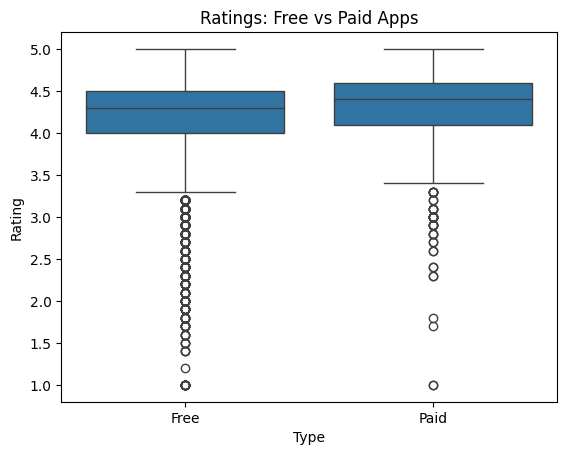

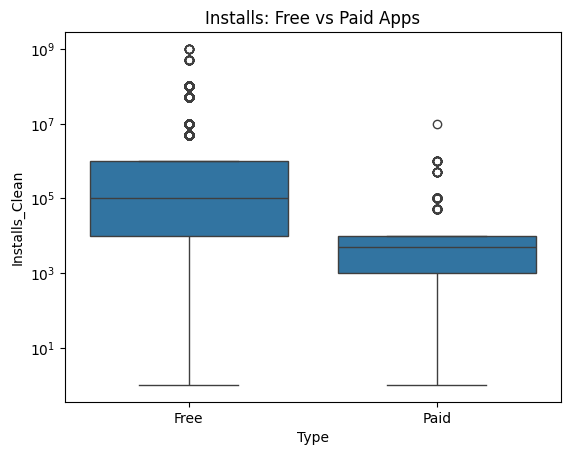

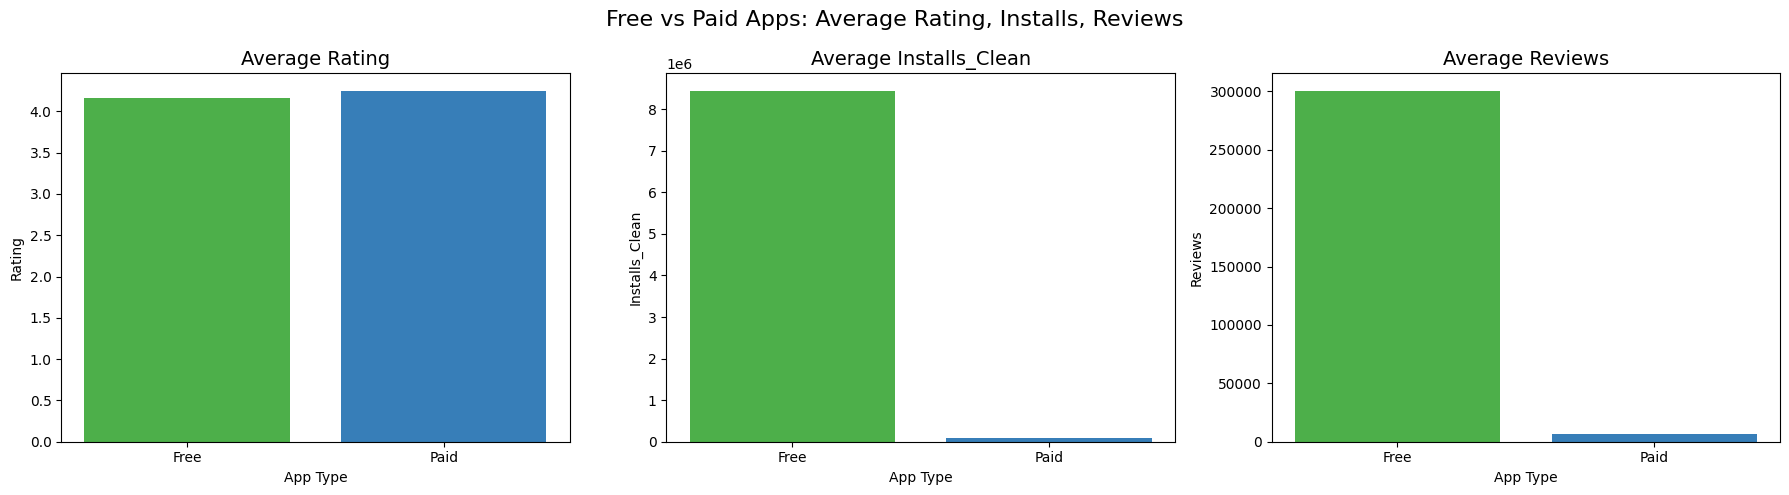

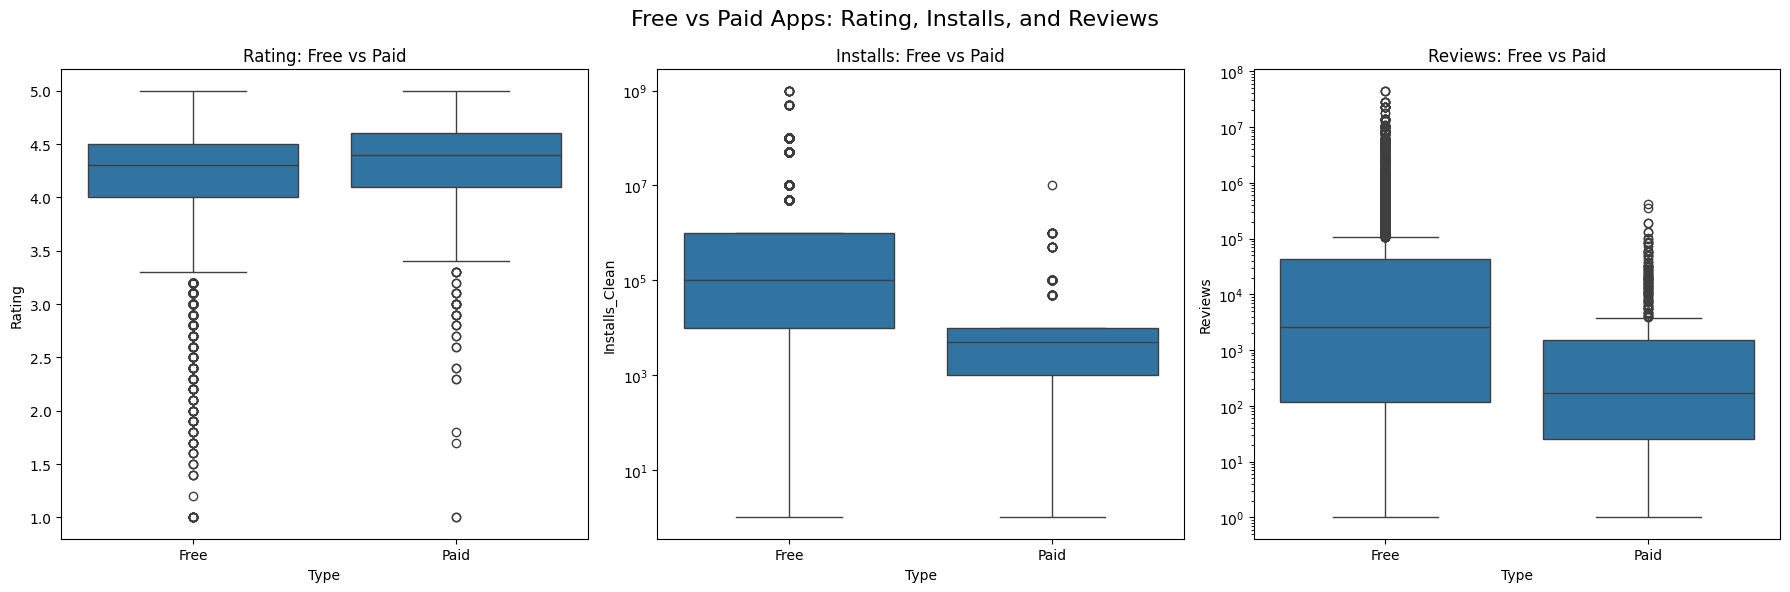

In [ ]:
# Q1 Are free apps more popular than paid apps?

# AI code:
# Boxplot of ratings
sns.boxplot(data=pandas_df, x="Type", y="Rating")
plt.title("Ratings: Free vs Paid Apps")
plt.show()

# Boxplot of installs
sns.boxplot(data=pandas_df, x="Type", y="Installs_Clean")
plt.yscale("log")  # installs can be skewed
plt.title("Installs: Free vs Paid Apps")
plt.show()

# need to see free vs paid
# Clean up 'Type' just in case
pandas_df["Type"] = pandas_df["Type"].str.strip()

# Group and calculate means
summary = pandas_df.groupby("Type")[["Rating", "Installs_Clean", "Reviews"]].mean().reset_index()

# Plot side-by-side bar charts
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["Rating", "Installs_Clean", "Reviews"]
colors = ['#4daf4a', '#377eb8']  # consistent colors

for i, metric in enumerate(metrics):
    ax[i].bar(summary["Type"], summary[metric], color=colors)
    ax[i].set_title(f"Average {metric}", fontsize=14)
    ax[i].set_ylabel(metric)
    ax[i].set_xlabel("App Type")

plt.suptitle("Free vs Paid Apps: Average Rating, Installs, Reviews", fontsize=16)
plt.tight_layout()
plt.show()

# was not seeing anything for paid apps, because apparently Price_float was null where
# type = paid so had to go back above and change the price_float to 1 where the
# associated type = paid

# looks like the boxplot shows that paid apps have slightly higher ratings overall
# while free apps have clearly more installs than paid

# ask AI for sumary boxplots for ratings installs clean and reviews

# Clean up 'Type'
pandas_df["Type"] = pandas_df["Type"].str.strip().str.title()

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Ratings
sns.boxplot(data=pandas_df, x="Type", y="Rating", ax=axes[0])
axes[0].set_title("Rating: Free vs Paid")

# Plot 2: Installs (log scale due to skew)
sns.boxplot(data=pandas_df, x="Type", y="Installs_Clean", ax=axes[1])
axes[1].set_title("Installs: Free vs Paid")
axes[1].set_yscale("log")

# Plot 3: Reviews (log scale due to skew)
sns.boxplot(data=pandas_df, x="Type", y="Reviews", ax=axes[2])
axes[2].set_title("Reviews: Free vs Paid")
axes[2].set_yscale("log")

plt.suptitle("Free vs Paid Apps: Rating, Installs, and Reviews", fontsize=16)
plt.tight_layout()
plt.show()

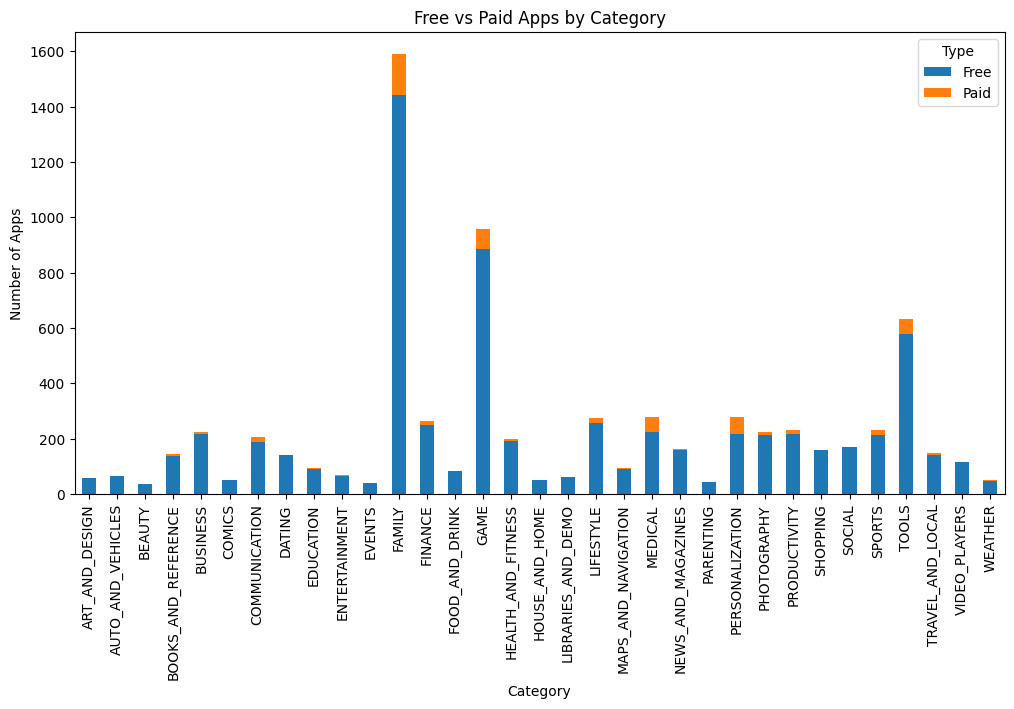

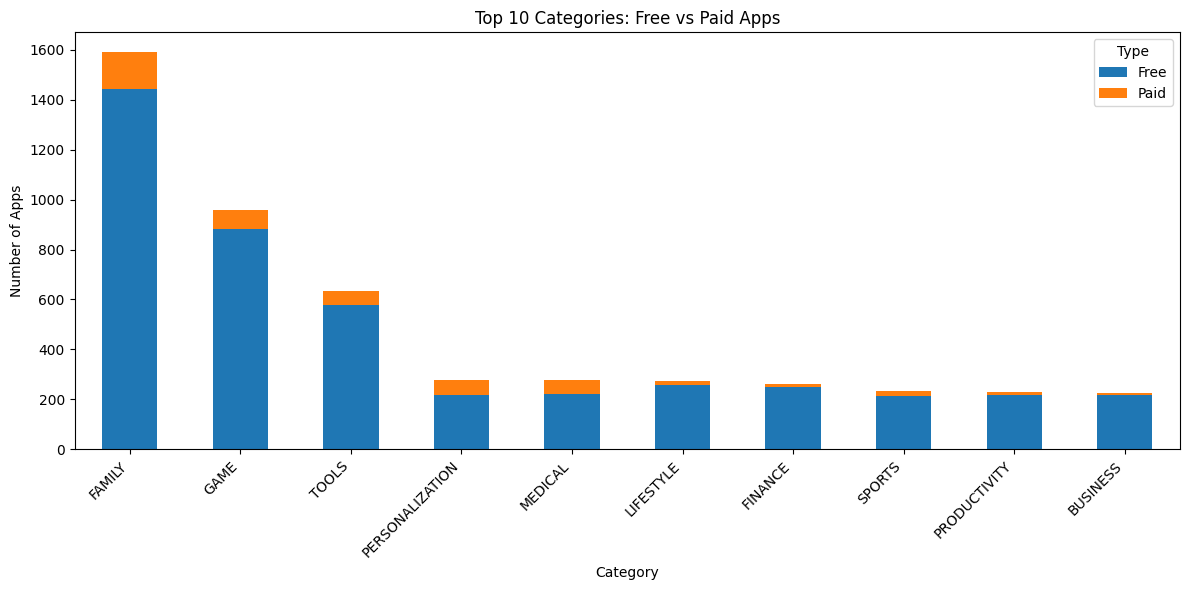

In [ ]:
# Q2 Are free/paid apps more prevalent in certain categories?
# AI code:
type_cat = pandas_df.groupby(['Category', 'Type']).size().unstack().fillna(0)

type_cat.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Free vs Paid Apps by Category")
plt.ylabel("Number of Apps")
plt.xticks(rotation=90)
plt.show()

# ask AI to sort bar chart and limit to top 10 categories

# new code:

# Clean Type field just in case
pandas_df["Type"] = pandas_df["Type"].str.strip().str.title()

# Group and unstack
type_cat = pandas_df.groupby(["Category", "Type"]).size().unstack(fill_value=0)

# Add a total column and sort
type_cat["Total"] = type_cat.sum(axis=1)
type_cat_sorted = type_cat.sort_values("Total", ascending=False)

# Keep top 10 categories
top10 = type_cat_sorted.head(10).drop(columns="Total")

# Plot
top10.plot(kind="bar", stacked=True, figsize=(12,6), color=["#1f77b4", "#ff7f0e"])
plt.title("Top 10 Categories: Free vs Paid Apps")
plt.xlabel("Category")
plt.ylabel("Number of Apps")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

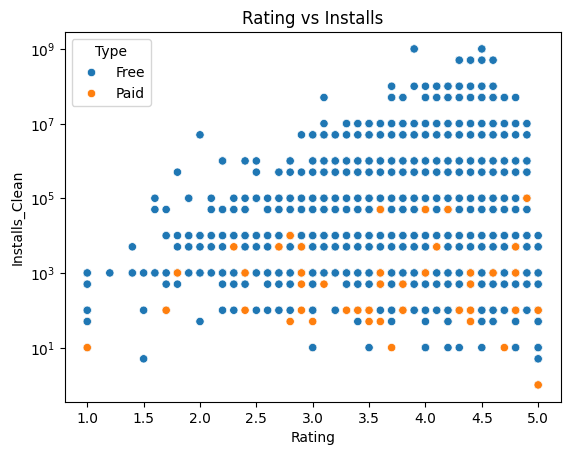

In [ ]:
# Q3. Does installs correlate with popularity (rating)?
# AI code:
sns.scatterplot(data=pandas_df, x="Rating", y="Installs_Clean", hue="Type")
plt.yscale("log")
plt.title("Rating vs Installs")
plt.show()



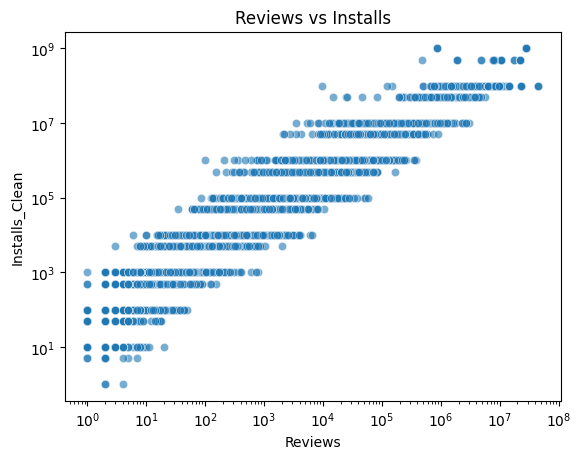

In [ ]:
# Q4. Does installs correlate with # of reviews?
# AI code:
sns.scatterplot(data=pandas_df, x="Reviews", y="Installs_Clean", alpha=0.6)
plt.xscale("log")
plt.yscale("log")
plt.title("Reviews vs Installs")
plt.show()

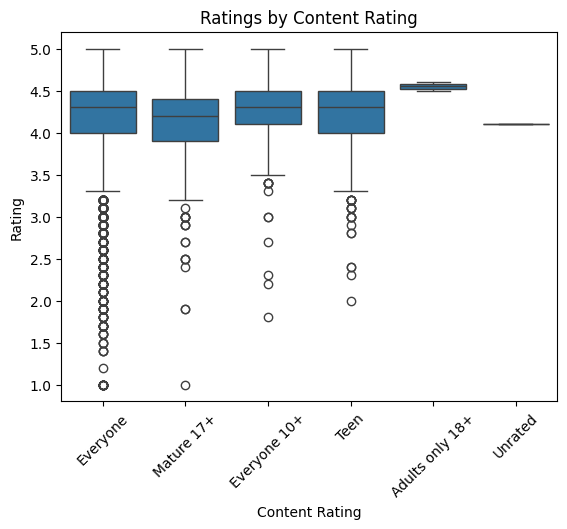

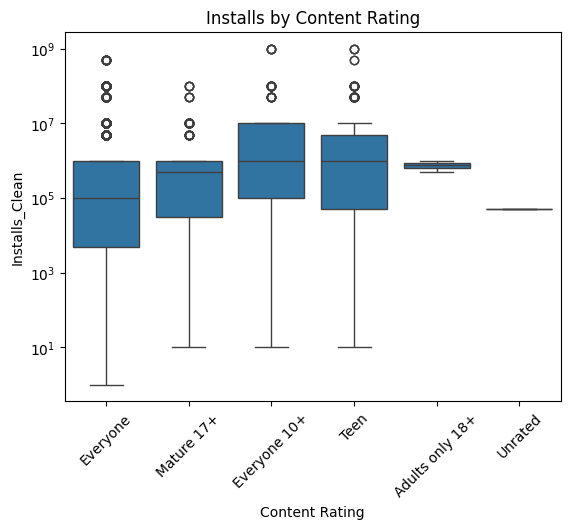

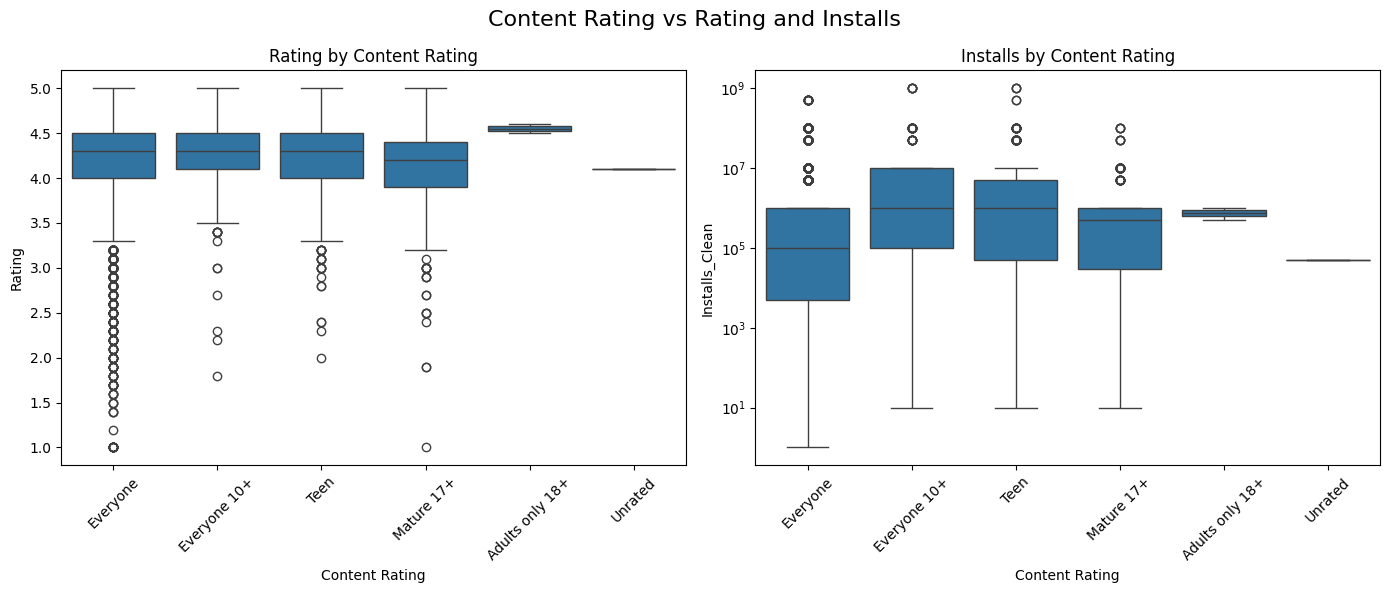

In [ ]:
#  Q5. Does content rating affect popularity (rating, installs)?
# AI code:
# Rating by content rating
sns.boxplot(data=pandas_df, x="Content Rating", y="Rating")
plt.xticks(rotation=45)
plt.title("Ratings by Content Rating")
plt.show()

# Installs by content rating
sns.boxplot(data=pandas_df, x="Content Rating", y="Installs_Clean")
plt.yscale("log")
plt.xticks(rotation=45)
plt.title("Installs by Content Rating")
plt.show()

#  ask AI to sort the content rating by "age" so its easier to visualize apps for everyone to adults
# AI code

# Define Ordered Categorical Type
from pandas.api.types import CategoricalDtype
age_order = CategoricalDtype(categories=[
    "Everyone", "Everyone 10+", "Teen", "Mature 17+", "Adults only 18+", "Unrated"
], ordered=True)

pandas_df["Content Rating"] = pandas_df["Content Rating"].astype(str).str.strip()
pandas_df["Content Rating"] = pandas_df["Content Rating"].astype(age_order)

# Redraw Your Boxplots Sorted by Age
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Ratings by content rating
sns.boxplot(data=pandas_df, x="Content Rating", y="Rating", ax=ax[0])
ax[0].set_title("Rating by Content Rating")
ax[0].tick_params(axis='x', rotation=45)

# Installs by content rating (log scale)
sns.boxplot(data=pandas_df, x="Content Rating", y="Installs_Clean", ax=ax[1])
ax[1].set_title("Installs by Content Rating")
ax[1].set_yscale("log")
ax[1].tick_params(axis='x', rotation=45)

plt.suptitle("Content Rating vs Rating and Installs", fontsize=16)
plt.tight_layout()
plt.show()

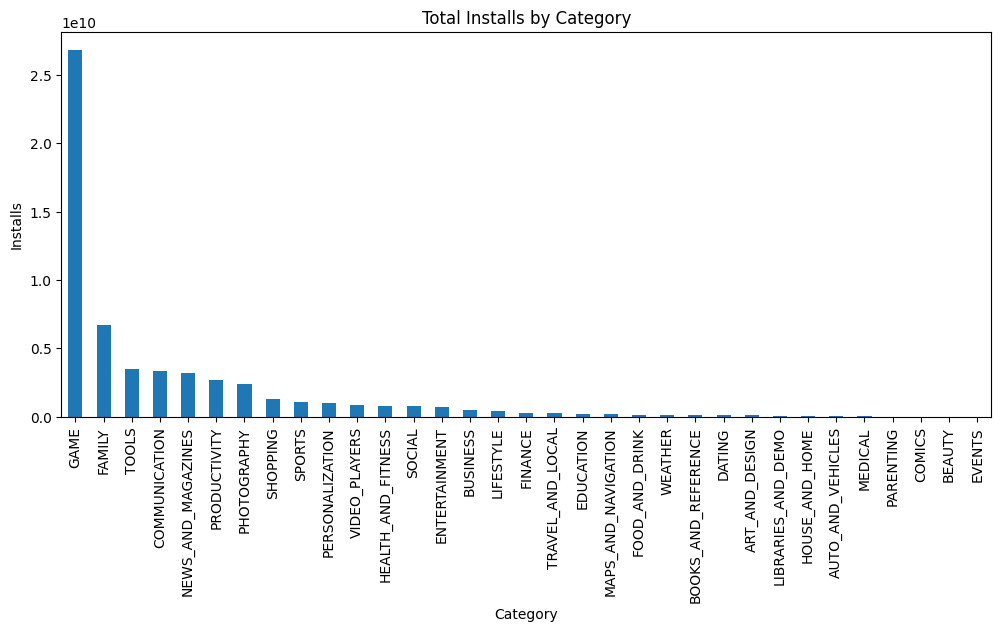

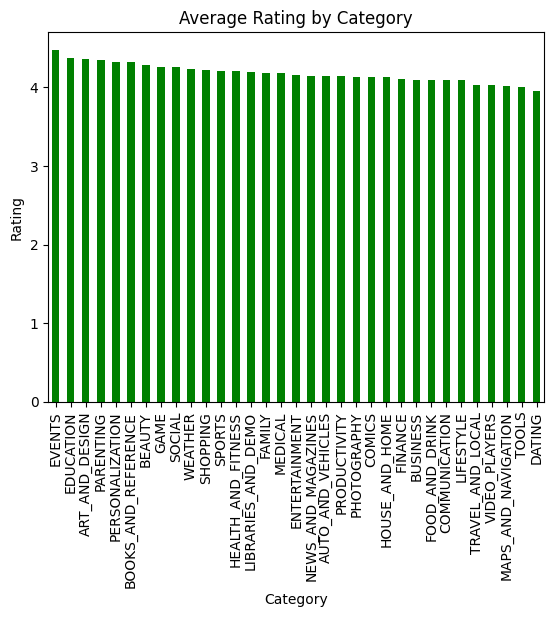

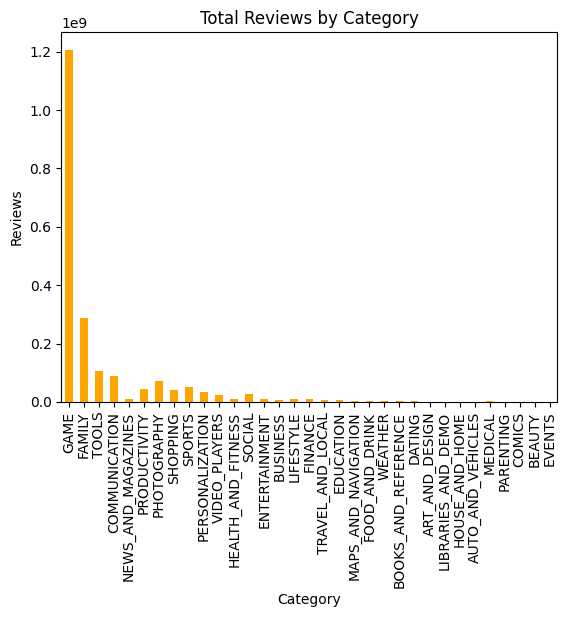

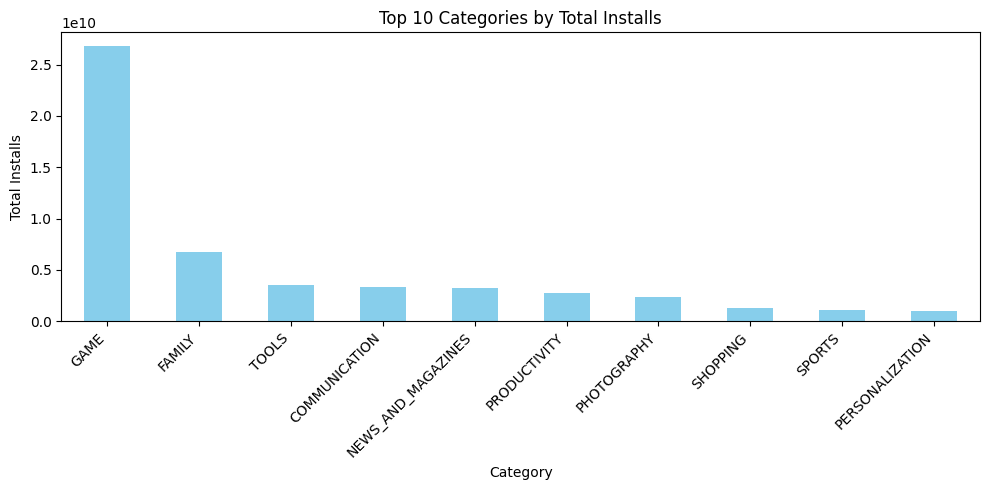

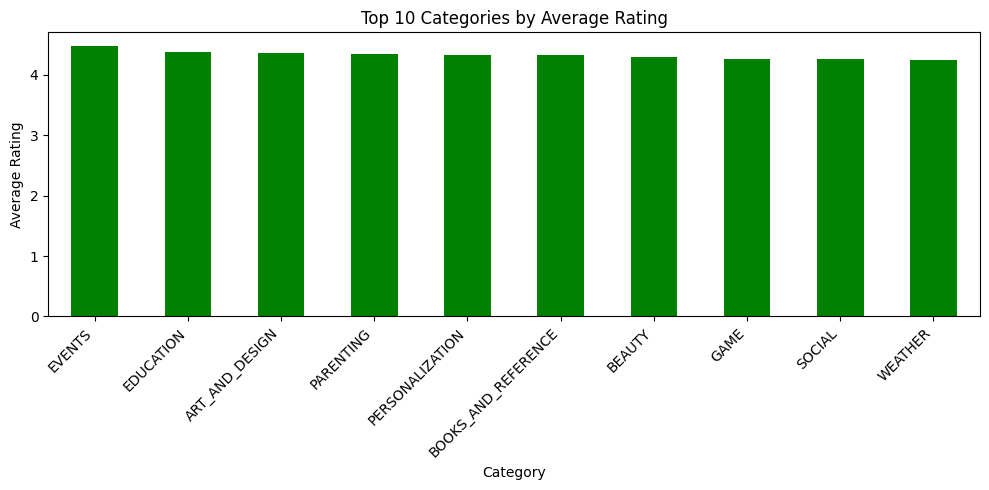

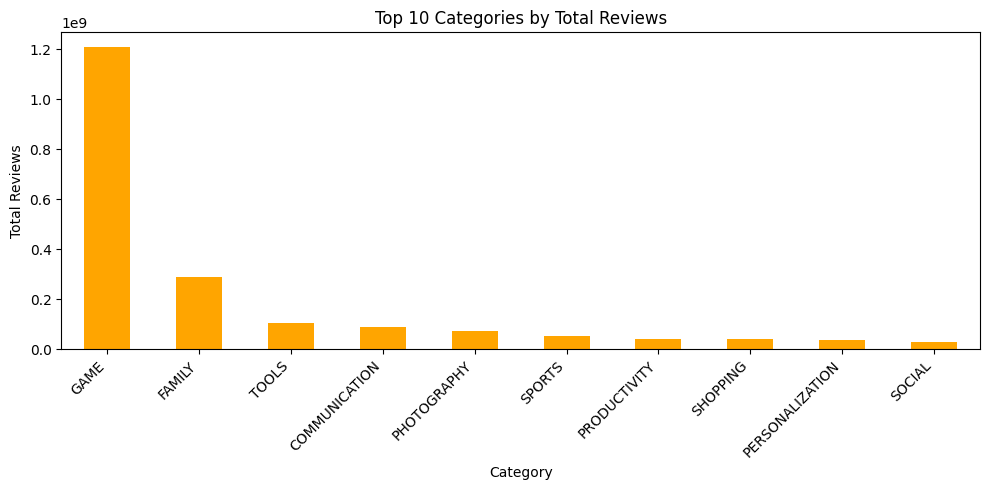

<ipython-input-27-7f003a96cd39>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


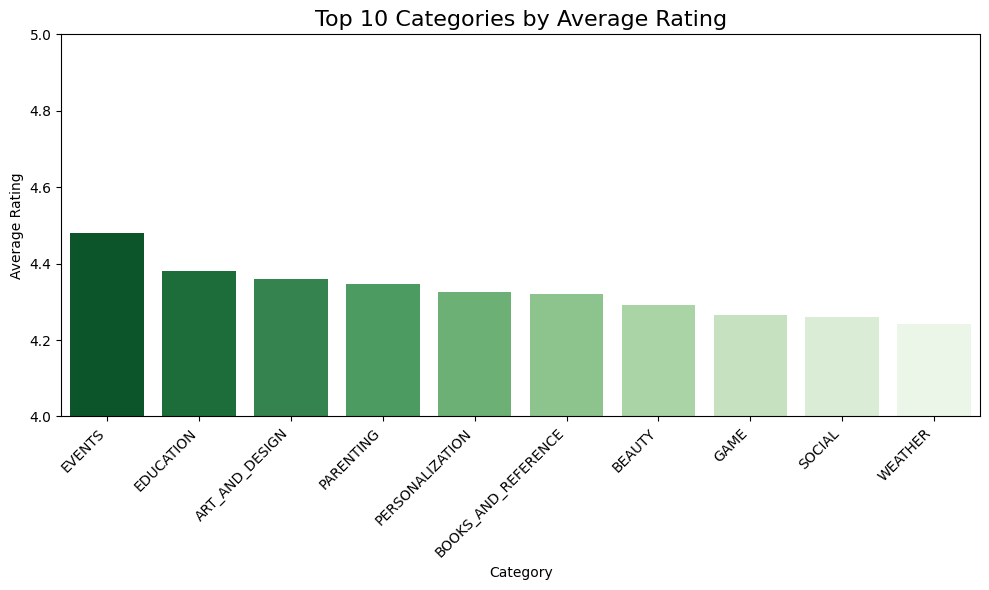

In [ ]:
# Q6. Which categories have most installs, highest ratings, most reviews?
category_stats = pandas_df.groupby("Category").agg({
    "Installs_Clean": "sum",
    "Reviews": "sum",
    "Rating": "mean"
}).sort_values(by="Installs_Clean", ascending=False)

# Most installs by category
category_stats["Installs_Clean"].plot(kind='bar', figsize=(12,5))
plt.title("Total Installs by Category")
plt.ylabel("Installs")
plt.xticks(rotation=90)
plt.show()

# Highest average ratings
category_stats.sort_values("Rating", ascending=False)["Rating"].plot(kind='bar', color='green')
plt.title("Average Rating by Category")
plt.ylabel("Rating")
plt.xticks(rotation=90)
plt.show()

# Most reviews
category_stats["Reviews"].plot(kind='bar', color='orange')
plt.title("Total Reviews by Category")
plt.ylabel("Reviews")
plt.xticks(rotation=90)
plt.show()

# ask AI to limit graphs by top 10 for each of the categories
# AI code

category_stats = pandas_df.groupby("Category").agg({
    "Installs_Clean": "sum",
    "Rating": "mean",
    "Reviews": "sum"
})

top_installs = category_stats.sort_values("Installs_Clean", ascending=False).head(10)

top_installs["Installs_Clean"].plot(kind="bar", figsize=(10,5), color="skyblue")
plt.title("Top 10 Categories by Total Installs")
plt.ylabel("Total Installs")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

top_rating = category_stats.sort_values("Rating", ascending=False).head(10)

top_rating["Rating"].plot(kind="bar", figsize=(10,5), color="green")
plt.title("Top 10 Categories by Average Rating")
plt.ylabel("Average Rating")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

top_reviews = category_stats.sort_values("Reviews", ascending=False).head(10)

top_reviews["Reviews"].plot(kind="bar", figsize=(10,5), color="orange")
plt.title("Top 10 Categories by Total Reviews")
plt.ylabel("Total Reviews")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ask AI to change top 10 categories by avg rating with a y-axis from 4->5 to make
# the differences more pronounced
top_rating = category_stats.sort_values("Rating", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_rating.index,
    y=top_rating["Rating"],
    palette="Greens_r"
)
plt.ylim(4.0, 5.0)  # Set scale to emphasize differences
plt.title("Top 10 Categories by Average Rating", fontsize=16)
plt.ylabel("Average Rating")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Save cleaned data file for Tableau usage

# saved to csv above
# pandas_df.to_csv('cleaned_app_data.csv', index=False)

## Data Analysis

In [ ]:
# Analysis Code Here - if needed
None

### Link to Published Dashboard

https://public.tableau.com/views/google_app/ContentRatingEffects?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

## Conclusion

The Google app store categories with the most apps are Family, Game, and Tools, far outpacing all other categories.

The Game category although 2nd to Family apps in terms of number of apps, has the most Reviews and Installations. By Content Rating, Everyone and Everyone 10+ game apps had the most Reviews and Installations.

If the focus is on the number of installations of the app, Having a highly rated app does not sseem to have a clear effect on number of installs. However, the Reviews metric has a clear effect on number of installs.

When it comes to the Content Rating of an app, it can be concluded that Everyone 10+ and Teen apps do better in terms of Ratings as well as Installs.

The recommendation to the leadership team would be to focus on the Games app category, with a targeted content rating of Everyone, Everyone 10+, and Teen.
Upon initial release there should be a focus on getting as many Reviews as possible to help drive installation rates.